In [2]:
library(tidyverse)
library(caret)
library(Biobase)
library(PharmacoGx)
library(Hmisc)
library(glmnet)
library(mRMRe)
library(SummarizedExperiment)
library(ggplot2)
library(EDASeq)
library(dplyr)
library(ggpubr)
library(gridExtra)
library(RColorBrewer)
library(ggfortify)
library(FactoMineR)
library(factoextra)
library(pheatmap)
library(AnnotationHub)
library(ensembldb)

In [3]:
options(stringsAsFactors = F)

# (1) <u>Identify Transcript Stability across Biological Replicates</u>

### Read in PSets

In [20]:
gCSI <- readRDS("gCSI.rds")

In [5]:
CCLE <- readRDS("CCLE.rds")

In [6]:
GDSC <- readRDS("GDSC2.rds")

### Read in biological replicates

In [7]:
load("inter.RData") #intersected_rnacells

### SummarizeMolecularProfiles (transcript counts) for biological replicates

In [8]:
gCSI_rna <- summarizeMolecularProfiles(pSet = gCSI, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)
GDSC_rna <- summarizeMolecularProfiles(pSet = GDSC, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)
CCLE_rna <- summarizeMolecularProfiles(pSet = CCLE, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)

Summarizing Kallisto_0.46.1.isoforms.counts molecular data for:	gCSI



  |======================================================================| 100%


Summarizing Kallisto_0.46.1.isoforms.counts molecular data for:	GDSC_v2



  |======================================================================| 100%


### Get all transcript.ids (they are the same across all PSets) N=227912

In [11]:
transcripts <- gCSI_rna@elementMetadata$transcript_id

### Determine pearson correlation for each transcript across datasets (gCSI vs CCLE; gCSI vs GDSC; GDSC vs CCLE), but only take median correlation for each transcript

In [12]:
transcript_stability <- data.frame(matrix(nrow=length(transcripts), ncol=2))
colnames(transcript_stability) <- c("transcript_id", "pearson")
transcript_stability$transcript_id <- transcripts
rownames(transcript_stability) <- transcript_stability$transcript_id

In [ ]:
for (i in 1:length(transcripts)){
  print(i)
  #gCSI vs CCLE
  expr_gcsi <- as.numeric(gCSI_rna@assays@data$exprs[i,])
  expr_ccle <- as.numeric(CCLE_rna@assays@data$exprs[i,])
  p_1 <- cor(expr_gcsi, expr_ccle, method = "pearson")
  
  #gCSI vs GDSC
  expr_gdsc <- as.numeric(GDSC_rna@assays@data$exprs[i,])
  p_2 <- cor(expr_gcsi, expr_gdsc, method = "pearson")
  
  #CCLE vs GDSC
  p_3 <- cor(expr_ccle, expr_gdsc, method = "pearson")
  
  if (is.na(p_1) | is.na(p_2) | is.na(p_3)){
    next
    
  } else {
  
  p_median <- median(p_1, p_2, p_3)
  #assign median correlation to df
  transcript_stability[i,"pearson"] <- p_median
  
  }
}

#save(transcript_stability, file="transcript_stability.RData")

In [13]:
load("transcript_stability.RData")

In [14]:
#remove transcripts that have no correlation (NA) - 8% of transcripts
transcript_stability <- transcript_stability[-which(is.na(transcript_stability$pearson)),]

### Correlation across biological replicates for each transcript (N=227912)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



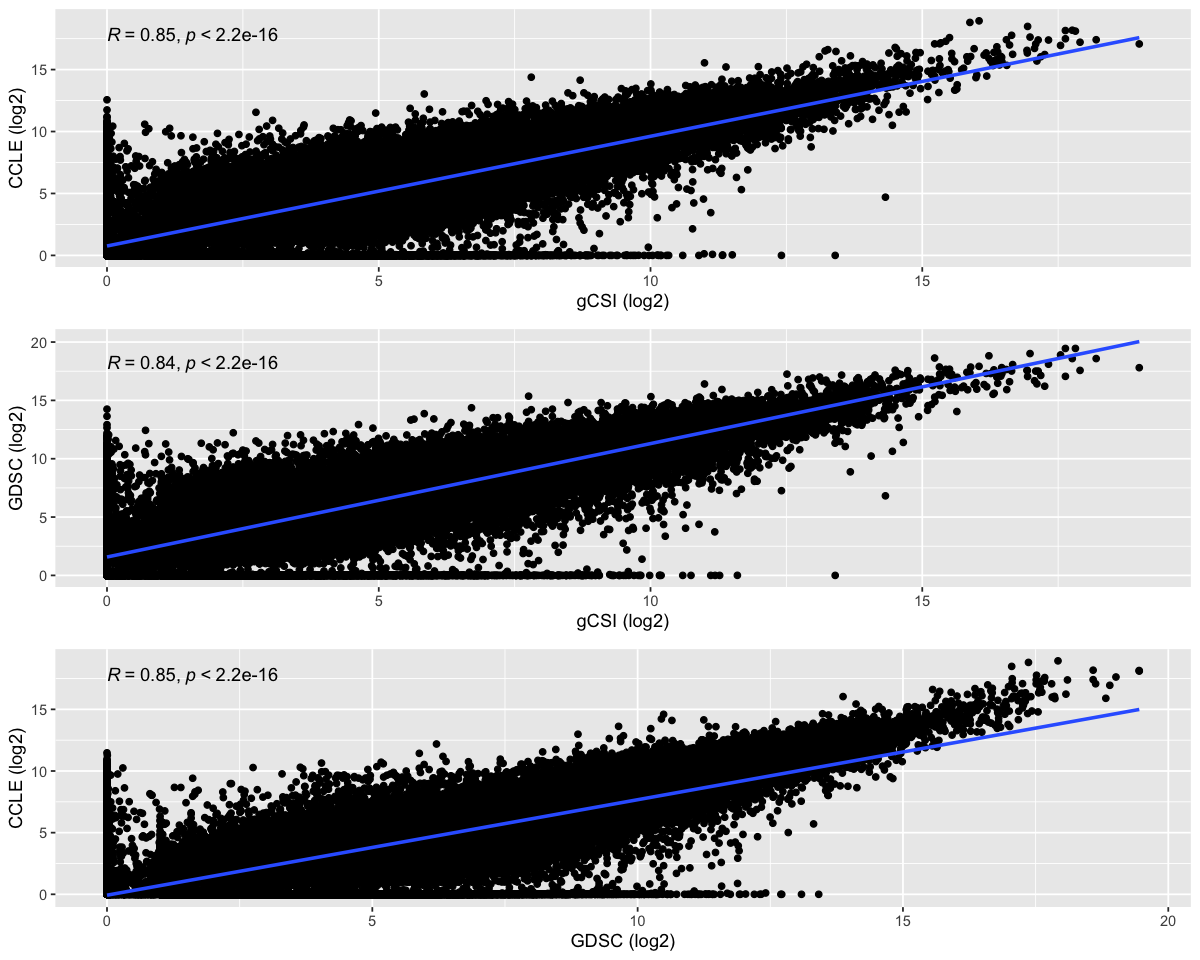

In [10]:
gcsi_ccle <- qplot(as.vector(t(gCSI_rna@assays@data$expr))[1:100000], y = as.vector(t(CCLE_rna@assays@data$expr))[1:100000], xlab = "gCSI (log2)", ylab = "CCLE (log2)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gcsi_gdsc <- qplot(as.vector(t(gCSI_rna@assays@data$expr))[1:100000], y = as.vector(t(GDSC_rna@assays@data$expr))[1:100000], xlab = "gCSI (log2)", ylab = "GDSC (log2)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gdsc_ccle <- qplot(as.vector(t(GDSC_rna@assays@data$expr))[1:100000], y = as.vector(t(CCLE_rna@assays@data$expr))[1:100000], xlab = "GDSC (log2)", ylab = "CCLE (log2)") + geom_smooth(method="lm") + stat_cor(method="pearson")
#gCSI vs CCLE = 0.7586281, gCSI vs GDSC = 0.7769999, GDSC vs CCLE = 0.7746946
options(repr.plot.width=10, repr.plot.height=8)
grid.arrange(gcsi_ccle, gcsi_gdsc, gdsc_ccle)

### Heatmap of transcript count across replicates

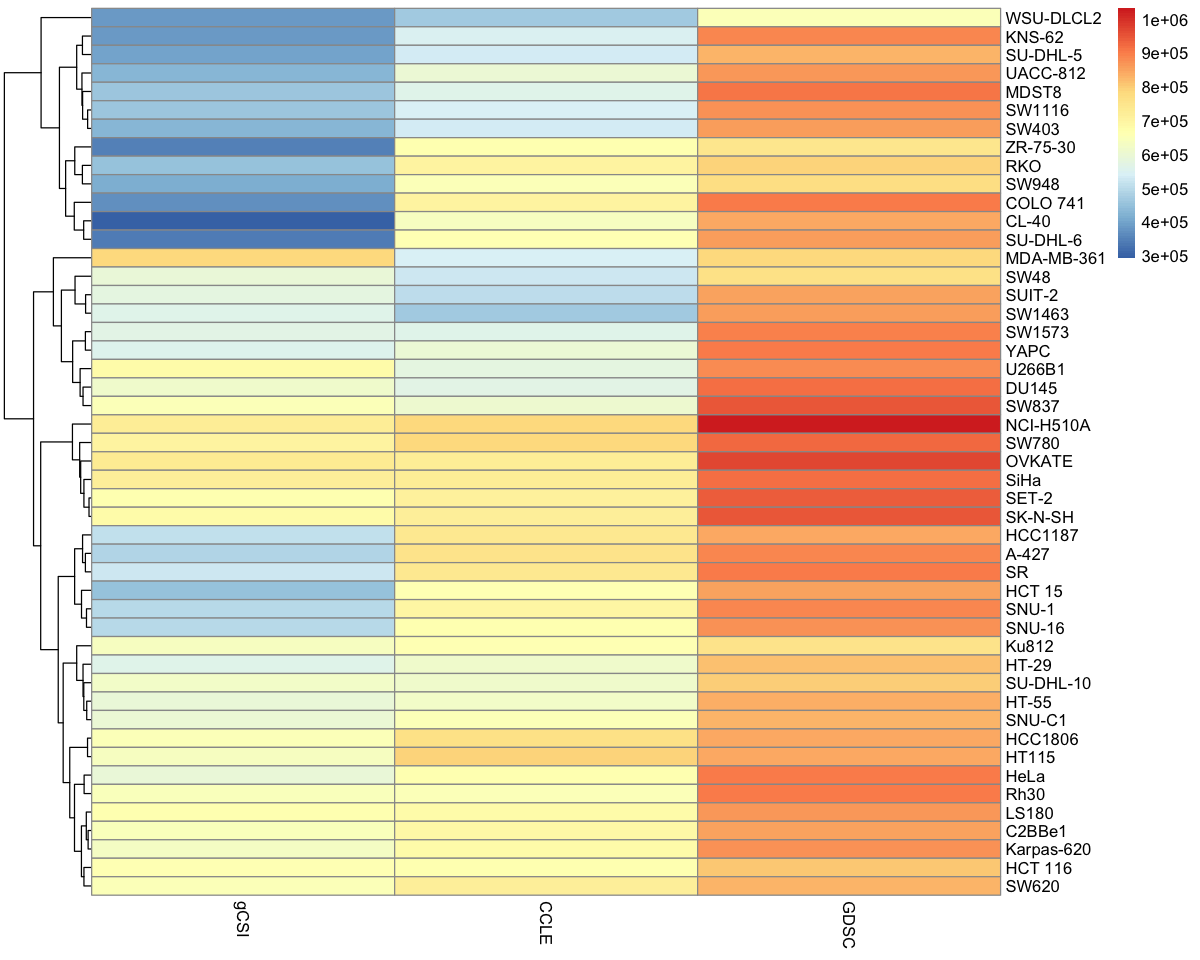

In [26]:
transcript_combined <- data.frame("gcsi"=as.numeric(colSums(gCSI_rna@assays@data$exprs)), 
                            "ccle"=as.numeric(colSums(CCLE_rna@assays@data$exprs)), 
                            "gdsc"=as.numeric(colSums(GDSC_rna@assays@data$exprs))
                            )

rownames(transcript_combined) <- intersected_rnacells
colnames(transcript_combined) <- c("gCSI","CCLE","GDSC")
transcript_combined <- as.matrix(transcript_combined)

options(repr.plot.width=10, repr.plot.height=8)
pheatmap(transcript_combined, cluster_rows=TRUE, show_rownames=TRUE,
         cluster_cols=FALSE)

### Sample-to-sample relationships (PCA)

In [24]:
gcsi_m <- as.data.frame(gCSI_rna@assays@data$exprs)
ccle_m <- as.data.frame(CCLE_rna@assays@data$exprs)
gdsc_m <- as.data.frame(GDSC_rna@assays@data$exprs)

colnames(gcsi_m) <- paste0("gcsi_", colnames(gcsi_m))
colnames(ccle_m) <- paste0("ccle_", colnames(ccle_m))
colnames(gdsc_m) <- paste0("gdsc_", colnames(gdsc_m))

combined_m <- as.data.frame(as.matrix(t(cbind.data.frame(gcsi_m,ccle_m,gdsc_m))))
combined_m <- combined_m
combined_m$dataset <- NA
combined_m$dataset[1:48] <- 'gCSI'
combined_m$dataset[49:96] <- 'CCLE'
combined_m$dataset[97:144] <- 'GDSC'

tt <- PCA(combined_m[,-227913], graph = FALSE)

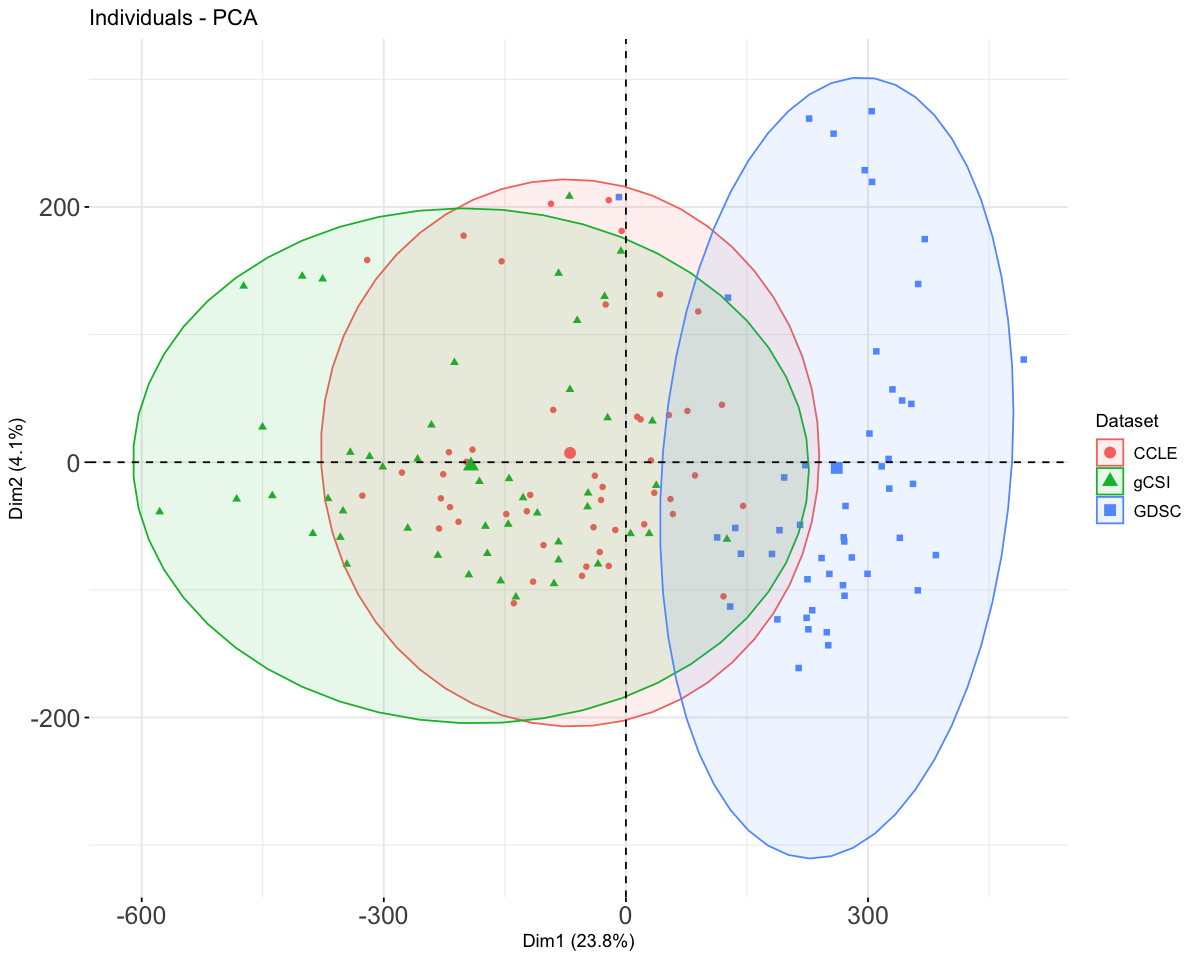

In [36]:
options(repr.plot.width=10, repr.plot.height=8)
fviz_pca_ind(tt,
             geom.ind = "point", # show points only (but not "text")
             col.ind = combined_m$dataset, # color by groups
             addEllipses = TRUE, # Concentration ellipses
             legend.title = "Dataset",
             labelsize = 15
) + theme(
    legend.text = element_text(size = 10),
    axis.text = element_text(size = 15)
  )

# (2) <u> Create ML model to predict transcript stability</u>

### Extract feature data from Ensembl

#### transcript %GC content + transcript length

In [21]:
expr_features <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata
expr_features$gene_id_stable <- gsub("\\..*","",expr_features$gene_id)

#use EDAseq package for retrieving gene %GC content & gene length from Ensembl GeneID
#length_gc <- getGeneLengthAndGCContent(expr_features$gene_id_stable, "hsa") #this takes about 30-40 min
#load("ensembl_length_gc.RData") #loads in gene length_gc

#transcript length from biomart ensembl
ensembl_features <- read.csv("ensembl_hg38_features.txt")
ensembl_features$transcript_length <- ensembl_features$Transcript.length..including.UTRs.and.CDS.

#transcript gc content(%) from AnnotationHub
require("ensembldb")
tt <- query(AnnotationHub(),"EnsDb", "v98")
tt <- subset(tt, species == "Homo sapiens") #identifies AH78783 as human ensembl v98
edb <- AnnotationHub()[["AH78783"]]
transcripts <- transcripts(edb)

snapshotDate(): 2020-04-27

snapshotDate(): 2020-04-27

loading from cache



#### miRNA binding sites

In [15]:
#miRNA binding sites
ensembl_features_miRNA <- read.csv("ensembl_hg38_features_miRNA.txt", sep = "\t") #miRNA bindings to gene

#get total # of miRNA binding sites per gene
mirna_total <- ensembl_features_miRNA %>% 
  group_by(Ensembl.gene.ID) %>% 
  summarise(miRNA.identifier = n_distinct(miRNA.identifier))

`summarise()` ungrouping output (override with `.groups` argument)



#### Exon rank in transcript

In [24]:
ensembl_features_rank <- read.csv("ensembl_hg38_features_exon_rank.txt", sep = "\t")

#### Number of exons in transcript

In [18]:
#exon number
ensembl_features_exon <- read.csv("ensembl_hg38_features_exon.txt")

#get total # of exons per transcript
exon_total <- ensembl_features_exon %>% 
  group_by(ensembl_features_exon$Transcript.stable.ID.version) %>% 
  summarise(Exon.stable.ID = n_distinct(Exon.stable.ID))

`summarise()` ungrouping output (override with `.groups` argument)



### Assemble feature data into dataframe

In [40]:
feature_df <- as.data.frame(matrix(NA, nrow = 227912))
feature_df$transcript_id <- as.character(gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_id)
feature_df$rank <- ensembl_features_rank$Exon.rank.in.transcript[match(feature_df$transcript_id, ensembl_features_rank$Transcript.stable.ID.version)]
feature_df$t_length <- ensembl_features$transcript_length[match(feature_df$transcript_id, ensembl_features$Transcript.stable.ID.version)]
feature_df$t_gc <- transcripts$gc_content[match(feature_df$transcript_id, transcripts$tx_id_version)]
feature_df$exon_num <- exon_total$Exon.stable.ID[match(feature_df$transcript_id, exon_total$`ensembl_features_exon$Transcript.stable.ID.version`)]
feature_df$type <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_type[match(feature_df$transcript_id, gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_id)]
feature_df$V1 <- NULL
rownames(feature_df) <- feature_df$transcript_id 
feature_df$transcript_id <- NULL

### Assign MEAN of feature for any NAs

In [41]:
#miRNA binding site count
#expr_features <- expr_features[match(mirna_total$Ensembl.gene.ID,expr_features$gene_id_stable),]
#expr <- expr[match(mirna_total$Ensembl.gene.ID,expr_features$gene_id_stable),] #only 14,000/60,000 kept
#expr$mirna <- mirna_total$miRNA.identifier[match(expr_features$gene_id_stable,mirna_total$Ensembl.gene.ID)]
#mean_mirna <- mean(expr$mirna[which(!is.na(expr$mirna))])
#expr$mirna[which(is.na(expr$mirna))] <- mean_mirna

#Exon rank in transcript
mean_rank <- mean(feature_df$rank[which(!is.na(feature_df$rank))])
feature_df$rank[which(is.na(feature_df$rank))] <- mean_rank

#Transcript length
mean_transcript_length <- mean(feature_df$t_length[which(!is.na(feature_df$t_length))])
feature_df$t_length[which(is.na(feature_df$t_length))] <- mean_transcript_length

#Transcript GC %
mean_gc <- mean(feature_df$t_gc[which(!is.na(feature_df$t_gc))])
feature_df$t_gc[which(is.na(feature_df$t_gc))] <- mean_gc

#Exon number in transcript
mean_exon_num <- mean(feature_df$exon_num[which(!is.na(feature_df$exon_num))])
feature_df$exon_num[which(is.na(feature_df$exon_num))] <- mean_exon_num

### Add transcript stability correlation to feature dataframe

In [42]:
feature_df$pearson <- transcript_stability$pearson[match(rownames(feature_df), transcript_stability$transcript_id)]
feature_df <- feature_df[-which(is.na(feature_df$pearson)),] #remove transcripts with NA (~8% removed)

### Use model.matrix to convert categorical variables in feature df to numerical (e.g. transcript_type)

In [44]:
feature_df_x <- model.matrix( ~ .-1, feature_df)

In [46]:
head(feature_df_x)

,rank,t_length,t_gc,exon_num,typeIG_C_gene,typeIG_C_pseudogene,typeIG_D_gene,typeIG_J_gene,typeIG_J_pseudogene,typeIG_pseudogene,⋯,typeTR_V_pseudogene,typetranscribed_processed_pseudogene,typetranscribed_unitary_pseudogene,typetranscribed_unprocessed_pseudogene,typetranslated_processed_pseudogene,typetranslated_unprocessed_pseudogene,typeunitary_pseudogene,typeunprocessed_pseudogene,typevaultRNA,pearson
ENST00000456328.2,1,1657,55.34098,3,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.60008490
ENST00000488147.1,1,1351,61.13990,11,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0.49231198
ENST00000619216.1,1,68,61.76471,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,-0.05511853
ENST00000473358.1,1,712,58.56742,3,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,-0.03040167
ENST00000469289.1,1,535,46.72897,2,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,-0.03040743
ENST00000417324.1,1,1187,53.32772,3,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,-0.03957004


### Plot feature distribution (feature vs transcript stability)

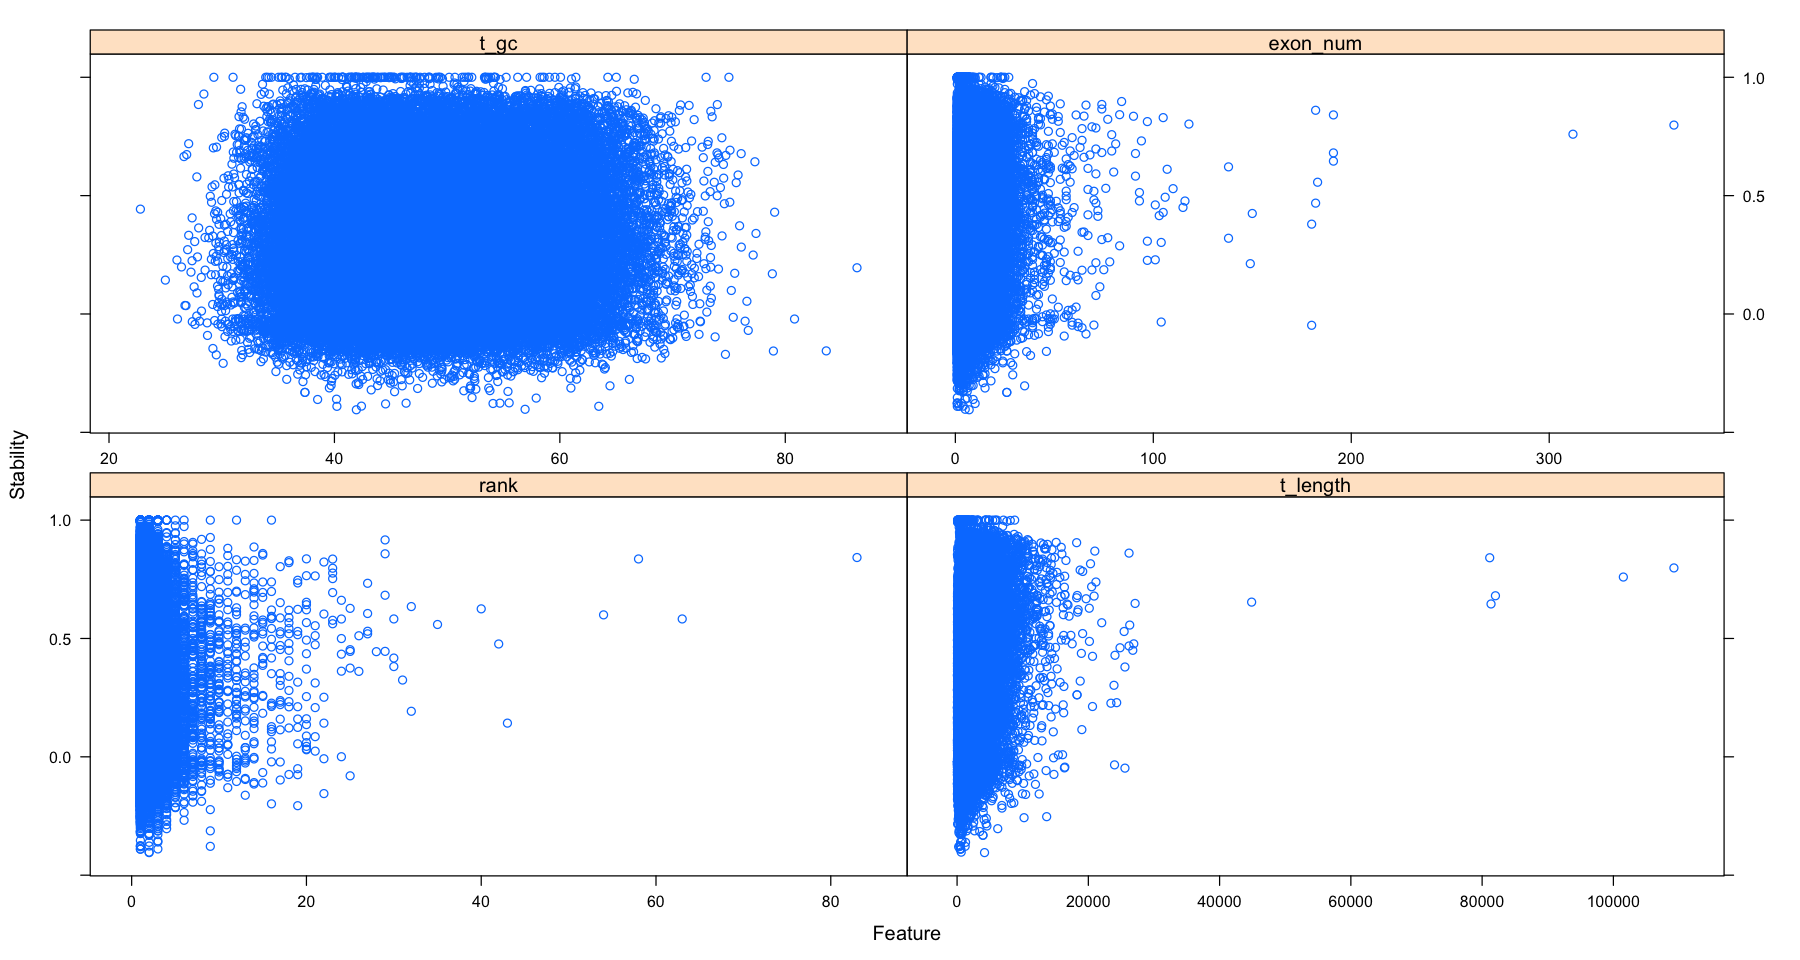

In [48]:
#use one cell line as example
expr_sub <- feature_df_x[1:50000, ]
options(repr.plot.width=15, repr.plot.height=8)
featurePlot(x = expr_sub[ , c("rank","t_length","t_gc","exon_num")], y = expr_sub[,"pearson"], labels = c("Feature", "Stability"))

# 1. <u>Elastic Net with K-fold cross validation</u>

In [49]:
set.seed(123)

### Train model

In [50]:
transcript_model <- train(
  pearson ~., #y-values (trying one sample)
  data=feature_df_x, #df with rows as samples and columns as features
  method = "glmnet",
  trControl = trainControl(
    method = "cv", 
    number = 10,
    verboseIter = TRUE
  )
)

+ Fold01: alpha=0.10, lambda=0.01294 
- Fold01: alpha=0.10, lambda=0.01294 
+ Fold01: alpha=0.55, lambda=0.01294 
- Fold01: alpha=0.55, lambda=0.01294 
+ Fold01: alpha=1.00, lambda=0.01294 
- Fold01: alpha=1.00, lambda=0.01294 
+ Fold02: alpha=0.10, lambda=0.01294 
- Fold02: alpha=0.10, lambda=0.01294 
+ Fold02: alpha=0.55, lambda=0.01294 
- Fold02: alpha=0.55, lambda=0.01294 
+ Fold02: alpha=1.00, lambda=0.01294 
- Fold02: alpha=1.00, lambda=0.01294 
+ Fold03: alpha=0.10, lambda=0.01294 
- Fold03: alpha=0.10, lambda=0.01294 
+ Fold03: alpha=0.55, lambda=0.01294 
- Fold03: alpha=0.55, lambda=0.01294 
+ Fold03: alpha=1.00, lambda=0.01294 
- Fold03: alpha=1.00, lambda=0.01294 
+ Fold04: alpha=0.10, lambda=0.01294 
- Fold04: alpha=0.10, lambda=0.01294 
+ Fold04: alpha=0.55, lambda=0.01294 
- Fold04: alpha=0.55, lambda=0.01294 
+ Fold04: alpha=1.00, lambda=0.01294 
- Fold04: alpha=1.00, lambda=0.01294 
+ Fold05: alpha=0.10, lambda=0.01294 
- Fold05: alpha=0.10, lambda=0.01294 
+ Fold05: al

In [51]:
transcript_model

glmnet 

208081 samples
    47 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 187273, 187273, 187272, 187273, 187273, 187273, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE       Rsquared    MAE      
  0.10   0.000129363  0.2595565  0.08737288  0.2139090
  0.10   0.001293630  0.2595557  0.08736231  0.2139385
  0.10   0.012936305  0.2597271  0.08647967  0.2145044
  0.55   0.000129363  0.2595573  0.08737817  0.2139021
  0.55   0.001293630  0.2595866  0.08720566  0.2140681
  0.55   0.012936305  0.2610854  0.07863656  0.2162442
  1.00   0.000129363  0.2595575  0.08737659  0.2139115
  1.00   0.001293630  0.2596565  0.08680570  0.2142220
  1.00   0.012936305  0.2624460  0.07048516  0.2177959

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.00129363.